# Machine Learning Engineer Nanodegree

## Capstone Project (Main Code)

Josen Alfonso Sanchez De Lucio

December 22, 2017

The python code presented in this notebook is the one used to obtain the results presented in the Capstone Project report. More information about it can be foun in the *README* file contained in this folfer. 

Train subject 1, class HandStart
Train subject 1, class FirstDigitTouch
Train subject 1, class BothStartLoadPhase
Train subject 1, class LiftOff
Train subject 1, class Replace
Train subject 1, class BothReleased
Train subject 2, class HandStart
Train subject 2, class FirstDigitTouch
Train subject 2, class BothStartLoadPhase
Train subject 2, class LiftOff
Train subject 2, class Replace
Train subject 2, class BothReleased
Train subject 3, class HandStart
Train subject 3, class FirstDigitTouch
Train subject 3, class BothStartLoadPhase
Train subject 3, class LiftOff
Train subject 3, class Replace
Train subject 3, class BothReleased
Train subject 4, class HandStart
Train subject 4, class FirstDigitTouch
Train subject 4, class BothStartLoadPhase
Train subject 4, class LiftOff
Train subject 4, class Replace
Train subject 4, class BothReleased
Train subject 5, class HandStart
Train subject 5, class FirstDigitTouch
Train subject 5, class BothStartLoadPhase
Train subject 5, class LiftOff
Train s

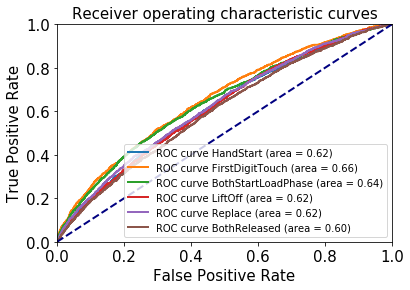


************************   BCI Average AR Capstpne Project results    ***************************

Metric\Event    HandStart    FirstDigitTouch    BothStartLoadPhase    LiftOff    Replace    BothReleased    
  Accuracy        0.897           0.899                0.897           0.894      0.898        0.895       
 Precision        0.169           0.208                0.173           0.148      0.171        0.134       

                    precision    recall  f1-score   support

         HandStart       0.17      0.09      0.11      1624
   FirstDigitTouch       0.21      0.11      0.14      1627
BothStartLoadPhase       0.17      0.09      0.12      1612
           LiftOff       0.15      0.08      0.10      1631
           Replace       0.17      0.08      0.11      1628
      BothReleased       0.13      0.07      0.09      1627

       avg / total       0.17      0.09      0.11      9749



In [18]:
"""
Created on Dec Sun 3 8:00:00 2017
Last modified on Dec Fri 9:20:00 2017

@author: Alfonso Sanchez De Lucio

--------------------------------Reference--------------------------------------
Structure based on the script made by Elena Cuoco, based on alexandrebarachant
starting script:
    
https://www.kaggle.com/elenacuoco/simple-grasp-with-sklearn/code
-------------------------------------------------------------------------------
"""
#******************************************************************************
#Importing libraries
#******************************************************************************
import numpy as np
import pandas as pd
import os
from glob import glob
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import fbeta_score, accuracy_score, precision_score
from sklearn.svm.libsvm import predict_proba
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
import time
from MLCapstoneFunctions import reading_data, data_preprocessing_PSD
from MLCapstoneFunctions import data_preprocessing_AR, data_preprocessing_TA
from MLCapstoneVisuals import *
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
#******************************************************************************
#Setting parameters and variables to consider
#******************************************************************************
subjects = range(1,13) #Numer of subject to consider
FramesLen=150          #Sie of the EEG segments 

#Finding my path and the train and test datasets paths:
Mypath = os.getcwd()   
TrainingPath = os.path.join(Mypath,'train','subj%d_series*_data.csv')
TestingPath = os.path.join(Mypath,'test','subj%d_series*_data.csv')

#Spaces to store variables
ids_tot = []
y_pred_tot = []
y_predproba_tot = []
Acura_tot = []
FbetA_tot = []
y_score_tot = []        
Correlations = {}

ARorder = 6             #Order for the AR modelling
beta=.5                 #In case a fbeta score used
Fs=500                  #Sample rate for the competition data
Fr=50                   #Maximun frequency to consider
timestart=time.clock()  #Time measuring
subsample=1             #In case a downsample is required

#Actions, or events of interest, to recognize
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

#Channels to consider for the recogniztion of events of interest
#channels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
channels = range(32)

#******************************************************************************
#Loop for the Kaggle datasets files, 6 series for train data + 2 series for test
#for each subject data
#******************************************************************************
for subject in subjects:
    y_raw= []
    raw = []

    ################ Reding the training data #################################
    #fnames =  glob('../input/train/subj%d_series*_data.csv' % (subject))
    fnames =  glob(TrainingPath % (subject))
    for fname in fnames:
      data,labels=reading_data(fname,'training')
      raw.append(data)
      y_raw.append(labels)

    X = pd.concat(raw)
    y = pd.concat(y_raw)

    #Transforming the train data into  numpy array
    X_train =np.asarray(X.astype(float))
    y = np.asarray(y.astype(float))

    ################ Reding the testing data ##################################
    #fnames =  glob('../input/test/subj%d_series*_data.csv' % (subject))
    fnames =  glob(TestingPath % (subject))
    test = []
    idx=[]
    y_raw_test= []
    for fname in fnames:
      data,labels=reading_data(fname,'testing')
      test.append(data)
      idx.append(np.array(data['id']))
      y_raw_test.append(labels)
    X_test= pd.concat(test)
    y_test= pd.concat(y_raw_test)
    ids=np.concatenate(idx)
    X_test=X_test.drop(['id' ], axis=1)#remove id
    
    #Transforming the test data into numpy array
    X_test =np.asarray(X_test.astype(float))
    y_test = np.asarray(y_test.astype(float))
        
    ################ Selecting the classifier #################################
    
    '''In case a SVC classifier is selected'''
    clf = SVC(kernel='poly',C=1, gamma=1, degree=3, probability=True, random_state=0) 
    
    '''In case a SVC with a GridSearch is selected'''
#    svc = SVC(kernel='poly',probability=True)
#    parameters = {'C':[1, 5, 10],'gamma':[.01, .1, 1], 'degree':[2, 3, 5]}
#    clf = GridSearchCV(svc, parameters)
#
    '''In case a MLP classifier is selected'''
#    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes = (75,2), random_state=0)
    
    '''In case a MLP with a GridSearch is selected'''
#    parameters = {'solver':['adam', 'sgd', 'lbfgs'],'hidden_layer_sizes':[(250, 2), (50, 2), (75, 2)]}
#    mlp = MLPClassifier(random_state=0)
#    clf = GridSearchCV(mlp, parameters)
    
    '''Others classifiers to select'''
    
#    clf = LogisticRegression()
#    clf = LinearDiscriminantAnalysis()
    
    ################ Preprocessing the data# ##################################
    
    #Preprocessing to select the EEG segments PSD as features
#    TrainData=data_preprocessing_PSD(X_train,y,None,'train', FramesLen ,ARorder,Fs,0,80)
#    TestData=data_preprocessing_PSD(X_test,y_test,ids,'test', FramesLen, ARorder,Fs,0,80)
    
    #Preprocessing to select the EEG segments AR coefficients as features
    TrainData=data_preprocessing_AR(X_train,y,None,'train', FramesLen ,ARorder)
    TestData=data_preprocessing_AR(X_test,y_test,ids,'test', FramesLen, ARorder)

    #Preparing the datasets
    X_train= TrainData[0]
    y = TrainData[1]    
    X_test = TestData[0]
    y_test = TestData[1]
    ids = TestData[2]
    
    #Preprocessing to select the EEG segments time domian amplitude as features
#    X_train = data_preprocessing_TA(X_train)
#    X_test = data_preprocessing_TA(X_test)
    
    ################ Training and testing the classifier ######################
    
    #Creating the space for various variables to be stored
    y_pred = np.zeros((X_test.shape[0],6))
    y_predproba = np.zeros((X_test.shape[0],6))
    y_score = np.zeros((X_test.shape[0],6))
    y_scoreb = np.zeros((X_test.shape[0],6))
    Acura = np.zeros(shape=(6))  
    ids_tot.append(ids)
    
    #Storing the real events of interest for the testing part to be compared 
    #againts the predicted, to calculate the preccision and accuracy of the 
    #selected clasiffier
    if subject==1:
        RealEvents = y_test
    else:
        RealEvents = np.concatenate((RealEvents,y_test), axis=0)
    
    #Training and Testing the selected classifier
    for i in range(6):
        y_train= y[:,i]
        print('Train subject %d, class %s' % (subject, cols[i]))
        clf.fit(X_train[::subsample,:],y_train[::subsample])
        clf.fit(X_train,y_train)
        y_pred[:,i] = clf.predict(X_test)
        y_predproba[:,i] = clf.predict_proba(X_test)[:,1]

    ################ Concatenating the obtained results #######################
    
    y_pred_tot.append(y_pred)
    y_predproba_tot.append(y_predproba)
    y_score_tot.append(y_score)
    ypred = np.concatenate(y_pred_tot)
    yscore = np.concatenate(y_score_tot)
    ypredproba = np.concatenate(y_predproba_tot)
    Correlations['subject%d' % (subject)] = np.corrcoef(X_train.transpose())
    
#******************************************************************************
#Prepraring and calculating results to be presented
#******************************************************************************   
    
#Time elapsed running the algorithm   
timeend=time.clock()
print('\nTime elapsed: ' + str((timeend-timestart)/60) + '[m]')

#Creating the space to store the Accuracy and Precision, and other metrics
Accuracy=np.zeros((RealEvents.shape[1]),dtype=float)
Precision=np.zeros((RealEvents.shape[1]),dtype=float)
fpr = dict()
tpr = dict()
thr = dict()
roc_auc = dict()

#Calculating the metrics
for n in range(RealEvents.shape[1]):
    Accuracy[n]=accuracy_score(RealEvents[:,n],ypred[:,n])
    Precision[n]=precision_score(RealEvents[:,n],ypred[:,n])
    fpr[n], tpr[n], _ = roc_curve(RealEvents[:,n],ypredproba[:,n])
    roc_auc[n] = auc(fpr[n], tpr[n])
    
# Computing the micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(RealEvents.ravel(), ypred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#******************************************************************************
#Showing the results obtained
#******************************************************************************   

#Showing the correlation between EEG features for all subjects of interst
#FeaturesRelationsLoop(Correlations, 'AR')

#Showiung the ROC cure for all events of interest
Plotting_ROCcurve(cols, fpr, tpr, roc_auc)

#Printing average results
AverageResults(Accuracy, Precision, cols, 'AR')

#Printing the classification_report
print(classification_report(RealEvents, ypred, target_names=cols))

#******************************************************************************
#Fin
#******************************************************************************  